# Creating Mountain Landscapes with Deep Convolutional Generative Adversarial Networks

## 1. Load Data

In [63]:
import tensorflow as tf
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
import pathlib
import glob
from PIL import Image
from skimage.transform import resize
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
from IPython import display

In [64]:
BASE_PATH = '/notebooks/storage/abstract_art_generator/'
img_size_target = 112
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [65]:
data_dir = pathlib.Path(BASE_PATH)
images = list(data_dir.glob('mountain_dataset/*.jpg'))
images[0].name

'13229.jpg'

In [27]:
train_images_org = ([( (np.array(load_img(BASE_PATH + 'mountain_dataset/{}'.format(file.name), color_mode='rgb')) - 127.5) / 127.5 ) for file in images])

print("{} is the original image dataset size.".format(train_images_org[0].shape))

train_images = [resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True) for img in train_images_org]
train_images = np.stack(train_images, axis=0)


(150, 150, 3) is the original image dataset size.


In [24]:
train_images = np.asarray(train_images).astype(np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. Models

### 2.1 Generator

In [66]:
# input vector
nz = 100
# size of image
ngf = 64
# number of channels
nc = 3

Hello


In [46]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(ngf*8, (4, 4), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(ngf*8, (4, 4), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Conv2DTranspose(ngf*4, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Conv2DTranspose(ngf*2, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Conv2DTranspose(ngf, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(nc, (2, 2), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(tf.keras.layers.Activation('tanh'))
    
    return model

In [77]:
generator = make_generator_model()

(None, 7, 7, 512)
(None, 7, 7, 512)
(None, 14, 14, 256)
(None, 28, 28, 128)
(None, 56, 56, 64)
(None, 112, 112, 3)


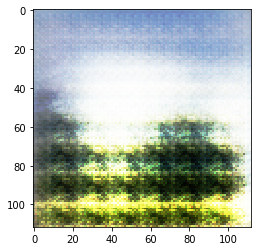

In [80]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False) 
plt.imshow(tf.cast(generated_image[0, :, :, :] * 127.5 + 127.5 , dtype='uint8'))

### 2.2 Discriminator

In [50]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[img_size_target, img_size_target, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [51]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00022548]], shape=(1, 1), dtype=float32)


### 2.3 Loss and Optimizer

In [52]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [53]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [54]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [55]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [56]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 3. Training

In [79]:
generator.load_weights('manually_saved_weights/generator/1000_epochs')
discriminator.load_weights('manually_saved_weights/discriminator/1000_epochs')

In [57]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [58]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
        
      real_output = discriminator(images, training=True)

      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    

    # finds the derivatives of the loss with respect to the training variables
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return (disc_loss, gen_loss)

In [59]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(tf.cast(predictions[i, :, :, :] * 127.5 + 127.5, dtype="uint8"))
      plt.axis('off')

#   plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [60]:
def train(dataset, epochs):
    loss_metrics = np.empty((1,2))

    for epoch in range(epochs):
        
        epoch_disc_loss, epoch_gen_loss = 0, 0
    
        start = time.time()

        for image_batch in dataset:
            (disc_loss, gen_loss) = train_step(image_batch)
            epoch_disc_loss += disc_loss
            epoch_gen_loss += gen_loss

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

            # Save the model every 15 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        loss_metrics = np.append(loss_metrics, [[epoch_disc_loss, epoch_gen_loss]], axis=0)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                       epochs,
                       seed)
    
    np.savetxt("disc_gen_loss.csv", loss_metrics, delimiter=",", header='Discriminator Loss, Generator Loss')

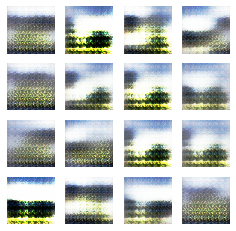

In [61]:
train(train_dataset, EPOCHS)

In [74]:
generator.save_weights('manually_saved_weights/generator/1000_epochs')
discriminator.save_weights('manually_saved_weights/discriminator/1000_epochs')

In [28]:
tf.saved_model.save(generator, "saved_model/1/generator")
tf.saved_model.save(discriminator, "saved_model/1/discriminator")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/1/generator/assets
INFO:tensorflow:Assets written to: saved_model/1/discriminator/assets


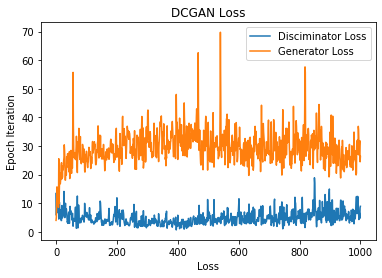

In [81]:
disc_loss, gen_loss = np.loadtxt('disc_gen_loss.csv', delimiter=',', unpack=True)
plt.plot(range(0,1001), disc_loss, label='Disciminator Loss')
plt.plot(range(0,1001), gen_loss, label='Generator Loss')

plt.xlabel('Loss')
plt.ylabel('Epoch Iteration')
plt.title('DCGAN Loss')
plt.legend()
plt.show()